In [1]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/')
from network import DSSM
from train import train
from load_data import load
from gpu_allocator import select_device
from gpu_allocator import cleanup_gpu_list
import torch
import csv
from test import test
from test import test_loader
from test import get_ndcg_precision_rr
import random
from train import generate_sparse

In [2]:
num_epochs = 2
epoch_size = 100
batch_size = 100
learning_rate = 0.1
embed_size = 128

print("Num of epochs:", num_epochs)
print("Epoch size:", epoch_size)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Embedding size:", embed_size)
rank = 10
test_batch =43
MODEL_PATH = "/home/jianx/data/results/"

Num of epochs: 2
Epoch size: 100
Batch size: 100
Learning rate: 0.1
Embedding size: 128


In [3]:
print("Loading data")
pos_neg_dict, query_dict, passage_dict, top_dict, rating_dict, query_test_dict = load()
print("Data successfully loaded.")
print("Positive Negative Pair dict size: " + str(len(pos_neg_dict)))
print("Num of queries: " + str(len(query_dict)))
print("Num of passages: " + str(len(passage_dict)))

Loading data
Data successfully loaded.
Positive Negative Pair dict size: 400782
Num of queries: 808731
Num of passages: 8841823


In [4]:
CURRENT_DEVICE = torch.device("cuda:0")
net = torch.load("/home/jianx/data/results/100_1500_100_0.1_256.model").to(CURRENT_DEVICE)

In [5]:
result_dict = test_loader(net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict, rating_dict)
qids = list(result_dict.keys())

[(5140587, 0.9971286654472351), (6093770, 0.9900366067886353), (2427575, 0.9865073561668396), (1301471, 0.9825977087020874), (2427569, 0.9732522964477539), (492722, 0.9614351987838745), (6990339, 0.9491649866104126), (2651080, 0.9443131685256958), (3539964, 0.9420167803764343), (625083, 0.919356644153595), (2204646, 0.9159924387931824), (3463552, 0.9153206944465637), (1529943, 0.908771812915802), (1375844, 0.8925108313560486), (5562279, 0.8922492861747742), (2329898, 0.8808342218399048), (7490451, 0.8763952255249023), (8614059, 0.8598634004592896), (8282175, 0.8472937941551208), (4699085, 0.8387308716773987), (6329928, 0.8265053629875183), (5457282, 0.8159202933311462), (8048972, 0.8158515095710754), (7421741, 0.786047101020813), (6199597, 0.7747673988342285), (2941400, 0.7714293599128723), (5690224, 0.7642930746078491), (4191391, 0.7426664233207703), (2514502, 0.7297932505607605), (6606723, 0.7199057936668396), (6643450, 0.7010195851325989), (1974327, 0.6981422305107117), (1301468, 0.

In [15]:
with open('/home/jianx/data/results/result.teIn', 'w+') as f:
    for qid in qids:
        for rank, item in enumerate(sorted(result_dict[qid].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)):
            f.write("{} Q0 {} {} {} run-id\n".format(qid, item[0],rank+1, item[1]))

(array([8095., 3888., 2621., 2021., 1361.,  996.,  875.,  735.,  683.,
         593.,  625.,  513.,  472.,  488.,  476.,  461.,  437.,  399.,
         362.,  368.,  254.,  242.,  191.,  177.,  138.,  155.,  137.,
         105.,  141.,  123.,  125.,  128.,  124.,  144.,  140.,  135.,
         135.,  163.,  139.,  145.,  140.,  111.,  107.,  113.,   75.,
          78.,   54.,   59.,   61.,   70.,   59.,   67.,   43.,   68.,
          45.,   55.,   38.,   45.,   49.,   50.,   41.,   51.,   39.,
          45.,   52.,   50.,   47.,   44.,   57.,   65.,   70.,   75.,
          64.,   78.,   67.,   83.,   90.,   58.,   66.,   70.,   57.,
          49.,   39.,   44.,   48.,   47.,   41.,   42.,   45.,   30.,
          43.,   45.,   35.,   29.,   39.,   38.,   35.,   27.,   31.,
          33.,   31.,   20.,   40.,   30.,   24.,   39.,   42.,   22.,
          39.,   30.,   22.,   26.,   34.,   32.,   32.,   35.,   31.,
          28.,   34.,   22.,   24.,   33.,   33.,   35.,   34.,   37.,
      

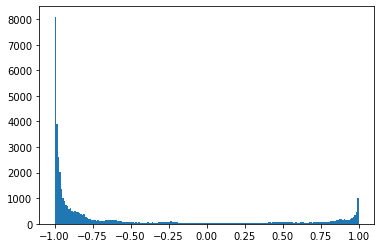

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
all_scores = []
for i in qids:
    for item in sorted(result_dict[i].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True):
        all_scores.append(item[1])
plt.hist(all_scores, bins=200)

In [51]:
top_pids = []
qid = 1
for i in range(10):
    top_pids.append(sorted(result_dict[qids[qid]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)[i][0])
print(top_pids)

[5978021, 5288186, 2211418, 4370203, 8031509, 6010960, 684093, 684084, 6773977, 5568229]


(array([763.,  32.,  22.,   9.,  10.,   5.,  15.,  13.,  20., 111.]),
 array([-9.99860346e-01, -7.99874693e-01, -5.99889040e-01, -3.99903387e-01,
        -1.99917734e-01,  6.79194927e-05,  2.00053573e-01,  4.00039226e-01,
         6.00024879e-01,  8.00010532e-01,  9.99996185e-01]),
 <a list of 10 Patch objects>)

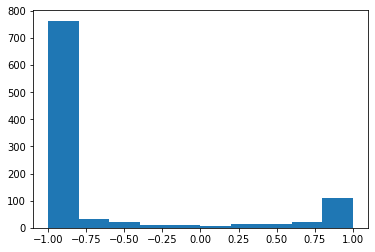

In [52]:
result0 = pd.DataFrame.from_dict(sorted(result_dict[qids[11]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True))
plt.hist(result0[1])

In [13]:
import numpy as np
result_ndcg = []
result_prec = []
result_rr = []
for qid in qids:
    ndcg, prec, rr = get_ndcg_precision_rr(rating_dict[qid], result_dict[qid], 10)
    result_ndcg.append(ndcg)
    result_prec.append(prec)
    result_rr.append(rr)
avg_ndcg = np.nanmean(result_ndcg)
avg_prec = np.nanmean(result_prec)
avg_rr = np.nanmean(result_rr)
print(avg_ndcg,avg_prec,avg_rr)

0.40996147699064384 0.10788812067881834 0.2926017011553549


In [30]:
test_qid = 1133167
test_pid = 6112590
test_q_embed = net(generate_sparse(query_test_dict[test_qid]).to(CURRENT_DEVICE)).detach()
test_p_embed = net(generate_sparse(passage_dict[test_pid]).to(CURRENT_DEVICE)).detach()
test_score = torch.cosine_similarity(test_q_embed.unsqueeze(0), test_p_embed.unsqueeze(0)).item()
print(test_score)
print(test_p_embed)

print(test_q_embed)

-0.8975946307182312
tensor([-3.0296e+03, -5.2848e+04,  2.3425e-02,  6.3025e-02, -1.0471e-01,
        -1.2495e+03,  2.3125e+04,  6.2536e-02,  1.3906e-01,  2.3375e+04,
        -2.5828e+04,  4.8552e+02, -4.4572e+03, -2.1202e+04, -2.2999e-02,
         9.1718e-02, -4.9721e+04, -4.0220e+03,  3.5009e-01, -2.2760e+04,
        -1.8646e+04,  1.6650e+03, -4.0550e+04, -2.2024e+04,  5.0473e+04,
        -4.8476e+04,  1.4154e+04, -1.0826e+03, -6.3183e+03,  1.4134e-01,
        -8.9433e+03,  3.2223e+04, -9.0528e+03,  5.4107e+04,  4.3253e+04,
        -1.0032e+04, -9.7527e+03, -4.7771e+04,  2.5884e+04, -7.8262e+03,
         2.0455e-01,  5.1378e+04,  9.3307e+03,  6.5136e+03,  1.5810e+04,
         1.3519e-02, -1.0916e+04, -9.4892e+02,  4.7940e+03,  8.1336e+03,
        -3.5506e+04,  5.5301e+04, -2.1024e+04, -7.8287e+03,  2.0133e+04,
         5.7350e+03,  4.4025e+04,  2.8542e-02,  2.8935e+04,  2.3223e+04,
        -4.4460e+04, -1.4056e+04,  4.0348e+04,  8.1690e+03, -2.3161e-02,
         9.8422e+03,  7.1057e+0